In [1]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
(raw_train, raw_validation), metadata= tfds.load('horses_or_humans', split=['train[:80]', 'train[80%:]'], with_info=True, as_supervised=True,)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/horses_or_humans/3.0.0.incompleteEAVVVQ/horses_or_humans-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/horses_or_humans/3.0.0.incompleteEAVVVQ/horses_or_humans-test.tfrecord


Dataset horses_or_humans downloaded and prepared to /root/tensorflow_datasets/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


In [3]:
print(raw_train)
print(raw_validation)

<DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>


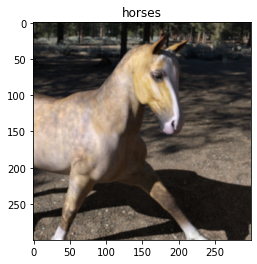

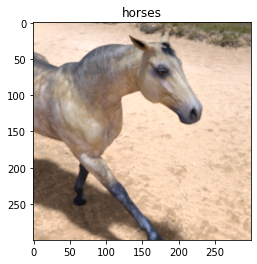

In [4]:
get_label_name= metadata.features['label'].int2str
for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [5]:
IMG_SIZE= 224
def format_example(image,label):
  image=tf.cast(image, tf.float32)
  image=(image/127.5) - 1
  image=tf.image.resize(image,(IMG_SIZE, IMG_SIZE))
  return image, label

In [6]:
train=raw_train.map(format_example)
validation=raw_validation.map(format_example)


In [7]:
BATCH_SIZE= 32
SHUFFLE_BUFFER_SIZE= 1000
train_batches=train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches= validation.batch(BATCH_SIZE)


In [8]:
for image_batch,label_batch in train_batches.take(1):
  pass
image_batch.shape


TensorShape([32, 224, 224, 3])

In [9]:
IMG_SHAPE=(IMG_SIZE, IMG_SIZE, 3)
base_model=tf.keras.applications.NASNetMobile(input_shape=IMG_SHAPE, include_top=False,weights='imagenet')

19996672/19993432 [==============================] - 0s 0us/step


In [10]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1056)


In [11]:
base_model.trainable= False

In [12]:
global_average_layer= tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average= global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1056)


In [13]:
prediction_layer= tf.keras.layers.Dense(1)
prediction_batch=prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [14]:
model=tf.keras.Sequential([
      base_model,
      global_average_layer,
      prediction_layer
])

In [15]:
base_learning_rate= 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1056)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1057      
Total params: 4,270,773
Trainable params: 1,057
Non-trainable params: 4,269,716
_________________________________________________________________


In [17]:
initial_epochs=40
history=model.fit(train_batches, epochs=initial_epochs, validation_data=validation_batches)

Epoch 1/40
3/3 [==============================] - 5s 2s/step - loss: 0.6248 - accuracy: 0.6625 - val_loss: 0.6528 - val_accuracy: 0.7610
Epoch 2/40
3/3 [==============================] - 1s 434ms/step - loss: 0.5959 - accuracy: 0.7250 - val_loss: 0.6277 - val_accuracy: 0.8000
Epoch 3/40
3/3 [==============================] - 1s 432ms/step - loss: 0.5773 - accuracy: 0.7500 - val_loss: 0.6123 - val_accuracy: 0.8098
Epoch 4/40
3/3 [==============================] - 1s 437ms/step - loss: 0.5623 - accuracy: 0.7875 - val_loss: 0.5969 - val_accuracy: 0.8244
Epoch 5/40
3/3 [==============================] - 1s 435ms/step - loss: 0.5486 - accuracy: 0.7875 - val_loss: 0.5823 - val_accuracy: 0.8341
Epoch 6/40
3/3 [==============================] - 1s 441ms/step - loss: 0.5370 - accuracy: 0.8000 - val_loss: 0.5655 - val_accuracy: 0.8439
Epoch 7/40
3/3 [==============================] - 1s 436ms/step - loss: 0.5241 - accuracy: 0.8125 - val_loss: 0.5558 - val_accuracy: 0.8585
Epoch 8/40
3/3 [=======

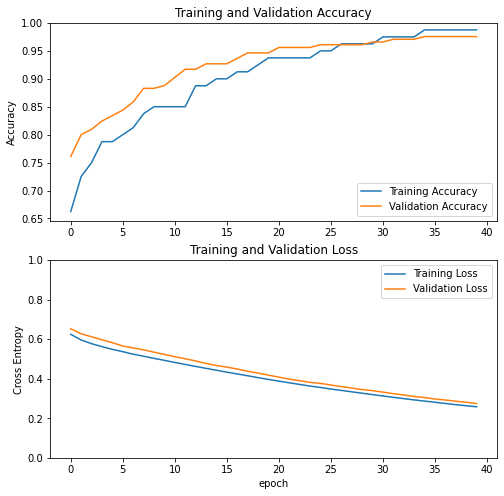

7/7 - 1s - loss: 0.2746 - accuracy: 0.9756

Test accuracy: 0.9756097793579102


In [18]:
#Evaluate the Model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
test_loss, test_acc = model.evaluate(validation_batches, verbose=2)
print('\nTest accuracy:', test_acc)

## FINE TUNING ##

In [20]:
base_model.trainable= True

In [21]:
print("Number of layers in the base model:",len(base_model.layers))

Number of layers in the base model: 769


In [22]:
fine_tune_at=729

In [23]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable= False

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits= True),optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1056)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1057      
Total params: 4,270,773
Trainable params: 341,441
Non-trainable params: 3,929,332
_________________________________________________________________


In [26]:
fine_tune_epochs= 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,epochs=total_epochs, initial_epoch= history.epoch[-1], validation_data= validation_batches)

Epoch 40/50
3/3 [==============================] - 5s 2s/step - loss: 0.2826 - accuracy: 0.9875 - val_loss: 0.2571 - val_accuracy: 0.9854
Epoch 41/50
3/3 [==============================] - 1s 444ms/step - loss: 0.2694 - accuracy: 0.9625 - val_loss: 0.2470 - val_accuracy: 0.9854
Epoch 42/50
3/3 [==============================] - 1s 429ms/step - loss: 0.2574 - accuracy: 0.9875 - val_loss: 0.2393 - val_accuracy: 0.9854
Epoch 43/50
3/3 [==============================] - 1s 430ms/step - loss: 0.2464 - accuracy: 0.9875 - val_loss: 0.2323 - val_accuracy: 0.9854
Epoch 44/50
3/3 [==============================] - 1s 437ms/step - loss: 0.2443 - accuracy: 0.9875 - val_loss: 0.2263 - val_accuracy: 0.9854
Epoch 45/50
3/3 [==============================] - 1s 439ms/step - loss: 0.2376 - accuracy: 0.9875 - val_loss: 0.2208 - val_accuracy: 0.9854
Epoch 46/50
3/3 [==============================] - 1s 431ms/step - loss: 0.2260 - accuracy: 0.9875 - val_loss: 0.2152 - val_accuracy: 0.9854
Epoch 47/50
3/3 

In [27]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

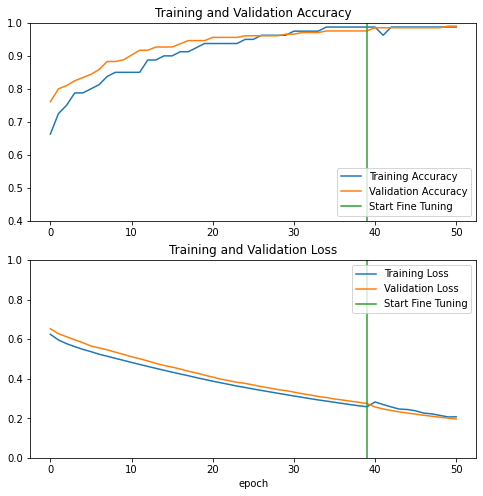

7/7 - 1s - loss: 0.1963 - accuracy: 0.9902

 Test accuracy: 0.9902439117431641


In [28]:
#Evaluate the Model
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
test_loss, test_acc = model.evaluate(validation_batches, verbose=2)
print('\n Test accuracy:', test_acc)